In [1]:
import torch
import scipy.stats
import matplotlib.pyplot as plt
import tqdm
import numpy as np

from IPython import display

from graph_plot_tools import *
from utils import *


In [2]:
x_label = "batch count"
title_fontsize = 14
xy_label_fontsize = 14

In [3]:
def smooth(a, eps=0.01, n_start=None):
    if n_start is not None and len(a) >= n_start:
        b = [np.array(a[:n_start]).mean()]
    else:
        b = [a[0]]
    for e in a[1:]:
        b.append(b[-1] * (1 - eps) + e * eps)
    return b

def get_std_for_group_uniques(
    tasks_history, grouped_hists,
    norm_train=False, 
    name_type="short_name", 
    center_train=False, 
    norm_train_name="train_loss_in_w_true", 
    center_train_name="train_loss_in_w_best",
    calc_std=False
):
    norm_train_modifier = 1.0
    center_train_modifier = 0.0
    groups = {}
    for hist in tasks_history:
        if not (hist["name"] in groups):
            groups[hist["name"]] = {"short_name":hist[name_type], "losses":{}}
        group_losses = groups[hist["name"]]["losses"]
        for loss_name in hist["losses"]:
            if not (loss_name in group_losses):
                group_losses[loss_name] = {}
                group_losses[loss_name]["max_len"] = 0
            group_losses[loss_name]["max_len"] = max(
                group_losses[loss_name]["max_len"], 
                len(hist["losses"][loss_name]["ys"])
            )
    
    for group_name in groups:
        group = groups[group_name]
        for loss_name in group["losses"]:
            group_loss = group["losses"][loss_name]
            group_loss["ys"] = np.zeros(group_loss["max_len"])
            group_loss["xs"] = np.zeros(group_loss["max_len"])
            group_loss["count"] = np.zeros(group_loss["max_len"])
            group_loss["x_step"] = -1
    
    for hist in tasks_history:
        group = groups[hist["name"]]
#         print(grouped_hists)
        grouped_means = grouped_hists[hist["name"]]
        
        if norm_train:
            norm_train_modifier = hist[norm_train_name]
        if center_train:
            center_train_modifier = hist[center_train_name]

        for loss_name in hist["losses"]:
            group_loss = group["losses"][loss_name]
            grouped_mean_loss = grouped_means["losses"][loss_name]
                 
            loss = hist["losses"][loss_name]
            loss_ys, loss_xs = np.array(loss["ys"]), np.array(loss["xs"])
            if "train" in loss_name:
                loss_ys = (loss_ys - center_train_modifier) / norm_train_modifier
            n = loss_ys.shape[0]
            group_loss["ys"][:n] += (loss_ys - grouped_mean_loss["ys"]) ** 2
            group_loss["xs"][:n] += loss_xs
            group_loss["count"][:n] += 1.0
            group_loss["x_step"] = loss["x_step"]
        if "task_params" in hist:
            group["task_params"] = hist["task_params"]
        else:
            group["task_params"] = {}
    
    for group_name in groups:
        group = groups[group_name]
        for loss_name in group["losses"]:
            group_loss = group["losses"][loss_name]
            group_loss["ys"] /= group_loss["count"]
            group_loss["ys"] = group_loss["ys"] ** 0.5
            group_loss["xs"] /= group_loss["count"]

    return groups

def group_uniques(
    tasks_history, 
    norm_train=False, 
    name_type="short_name", 
    center_train=False, 
    norm_train_name="train_loss_in_w_true", 
    center_train_name="train_loss_in_w_best",
    calc_std=False
):
    norm_train_modifier = 1.0
    center_train_modifier = 0.0
        
    groups = {}
    for hist in tasks_history:
        if not (hist["name"] in groups):
            groups[hist["name"]] = {"short_name":hist[name_type], "losses":{}, "norm_diff":None}
        group_losses = groups[hist["name"]]["losses"]
        for loss_name in hist["losses"]:
            if not (loss_name in group_losses):
                group_losses[loss_name] = {}
                group_losses[loss_name]["max_len"] = 0
            group_losses[loss_name]["max_len"] = max(
                group_losses[loss_name]["max_len"], 
                len(hist["losses"][loss_name]["ys"])
            )

    for hist in tasks_history:
        if groups[hist["name"]]["norm_diff"] is None:
            groups[hist["name"]]["norm_diff"] = {"diffs": [], "xs": [], "x_step": -1, "epochs": []}
        h_group = groups[hist["name"]]["norm_diff"]
        h = hist["norm_diff"]

        groups[hist["name"]]["norm_diff"]["xs"] = \
            h["xs"] if len(h["xs"]) > len(h_group["xs"]) else h_group["xs"]

        groups[hist["name"]]["norm_diff"]["x_step"] = h["x_step"]

        groups[hist["name"]]["norm_diff"]["epochs"] = \
            h["epochs"] if len(h["epochs"]) > len(h_group["epochs"]) else h_group["epochs"]

        if len(groups[hist["name"]]["norm_diff"]["diffs"]) == 0:
            groups[hist["name"]]["norm_diff"]["diffs"] = [[t] for t in h["diffs"]]
        else:
            for norm_diffs_i, norm_diffs in enumerate(h["diffs"]):
                groups[hist["name"]]["norm_diff"]["diffs"][norm_diffs_i].append(norm_diffs)
    
    for group_name in groups:
        group = groups[group_name]
        for loss_name in group["losses"]:
            group_loss = group["losses"][loss_name]
            group_loss["ys"] = np.zeros(group_loss["max_len"])
            group_loss["xs"] = np.zeros(group_loss["max_len"])
            group_loss["count"] = np.zeros(group_loss["max_len"])
            group_loss["x_step"] = -1
    
    for hist in tasks_history:
        group = groups[hist["name"]]
        
        if norm_train:
            norm_train_modifier = hist[norm_train_name]
        if center_train:
            center_train_modifier = hist[center_train_name]

        for loss_name in hist["losses"]:
            group_loss = group["losses"][loss_name]
            loss = hist["losses"][loss_name]
            loss_ys, loss_xs = np.array(loss["ys"]), np.array(loss["xs"])
            if "train" in loss_name:
                loss_ys = (loss_ys - center_train_modifier) / norm_train_modifier
            n = loss_ys.shape[0]
            group_loss["ys"][:n] += loss_ys
            group_loss["xs"][:n] += loss_xs
            group_loss["count"][:n] += 1.0
            group_loss["x_step"] = loss["x_step"]
        if "task_params" in hist:
            group["task_params"] = hist["task_params"]
        else:
            group["task_params"] = {}
    
    for group_name in groups:
        group = groups[group_name]
        for loss_name in group["losses"]:
            group_loss = group["losses"][loss_name]
            group_loss["ys"] /= group_loss["count"]
            group_loss["xs"] /= group_loss["count"]

        for norm_diffs_group_i, norm_diffs_group in enumerate(group["norm_diff"]["diffs"]):
            means = []
            stds = []
            for norm_diffs_i, norm_diffs in enumerate(norm_diffs_group):
                means.append(norm_diffs.mean())
                stds.append(norm_diffs.std())
                norm_diffs_group[norm_diffs_i] = (norm_diffs - norm_diffs.mean()) / norm_diffs.std()
            mean = np.mean(means)
            std = np.mean(stds)
            group["norm_diff"]["diffs"][norm_diffs_group_i] = np.concatenate(norm_diffs_group) * std + mean

    if calc_std:
        groups_stds = get_std_for_group_uniques(tasks_history, groups)
        for group_name in groups:
            group = groups[group_name]
            group_stds = groups_stds[group_name]
            for loss_name in group["losses"]:
                group_loss = group["losses"][loss_name]
                group_loss_std = group_stds["losses"][loss_name]
                group_loss["ys_std"] = group_loss_std["ys"]

    return groups


def make_loss_plot(ax, tasks_history_grouped, loss_name, loss_title_name,
                x_label="Iteration", start_x=0, end_x=None, alpha=0.8, linestyle="-", eps=0.01, legend=False,
                x_scale="linear", y_scale="linear", smooth_n_start=None, n_train=5000, eps_auto=False
                ):
    if len(tasks_history_grouped) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(tasks_history_grouped)))

    plot_params = {"alpha":alpha, "linestyle":linestyle}
    

    for i, group_name in enumerate(tasks_history_grouped):
        group = tasks_history_grouped[group_name]["losses"]
        xs = group[loss_name]["xs"][start_x:end_x]
        ys = group[loss_name]["ys"][start_x:end_x]
        if eps_auto:
            local_eps = eps / (n_train / group[loss_name]["x_step"])
        else:
            local_eps = eps
        smoothed_ys = smooth(ys, eps=local_eps, n_start=smooth_n_start)
        group_name_for_legend = group_name
        if "short_name" in tasks_history_grouped[group_name]:
            group_name_for_legend = tasks_history_grouped[group_name]["short_name"]
        ax.plot(
            xs, smoothed_ys, label=group_name_for_legend, color=colors[i], 
            **plot_params
        )

    ax.set_title("{} for different tasks".format(loss_title_name))
    ax.set_ylabel("{}".format(loss_title_name))
    ax.set_xlabel(x_label)
    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)
    ax.grid(True)
    plt.tight_layout()
    if legend:
        ax.legend()

    return ax


def draw_norm_hist(ax, norm_diffs, bins_n=100, draw_normal=True):
    counts, bins = np.histogram(norm_diffs, bins_n, density=True)

    if draw_normal:
        mu = np.mean(norm_diffs)
        sigma = np.sqrt(np.mean((norm_diffs - mu)**2))
        temp2 = np.linspace(bins[0], bins[-1], bins_n)
        y = scipy.stats.norm.pdf(temp2, mu, sigma)
        temp2 = temp2[y > (counts[counts > 0]).min()]

        ax.plot(
            temp2, scipy.stats.norm.pdf(temp2, mu, sigma), 
            linewidth=2, color='red'
        )

    ax.hist(bins[:-1], bins, weights=counts)

    return ax


def draw_norm_hists_for_different_models(fig, subplotspec_outer, tasks_history_grouped, bins_n=100, draw_normal=True, number=-1):
    h = (len(tasks_history_grouped) + 2) // 3
    sgs = subplotspec_outer.subgridspec(h, 3, wspace=0.15, hspace=0.6)
    for i, group_name in enumerate(tasks_history_grouped):
        group = tasks_history_grouped[group_name]["norm_diff"]
        ax = fig.add_subplot(sgs[i // 3, i % 3])
        if len(group["diffs"]) > 0:
            ax = draw_norm_hist(ax, group["diffs"][number], bins_n=bins_n, draw_normal=draw_normal)
            label = group_name
            ax.set_title("{},\n batch_count={}, skew={:0.2f}".format(
                label, 
                len(group["diffs"][number]), 
                stats.skew(group["diffs"][number])
            ), fontsize=11)
        ax.set_ylabel("Density")
        ax.set_xlabel("Noise norm")
        ax.grid(True)

    ax = plt.Subplot(fig, subplotspec_outer)
    ax.set_title("Distribution of the gradient noise for different optimizers", y=1.15, fontsize=14)
    ax.set_frame_on(False)
    ax.axis('off')
    fig.add_subplot(ax)

    return ax


def draw_norm_hists_for_one_model(
    ax, hist, 
    title, y_label="density", x_label="noise norm", 
    bins_n=100, draw_normal=True, number=-1, grid=True, 
    add_batch_count=True, round_batch_count=True, 
    title_fontsize=14, xy_label_fontsize=10
):
    one_optim_hist = hist[0]
    ax = draw_norm_hist(ax, one_optim_hist["norm_diff"]["diffs"][number], bins_n=bins_n, draw_normal=draw_normal)
    
    batch_count = len(one_optim_hist["norm_diff"]["diffs"][number])
    if round_batch_count:
        batch_count = "~{}k".format(batch_count // 1000)
    if add_batch_count:
        title = "{}, batch count={}".format(title, batch_count)

    ax.set_title(title, fontsize=title_fontsize)
    ax.set_ylabel(y_label, fontsize=xy_label_fontsize)
    ax.set_xlabel(x_label, fontsize=xy_label_fontsize)
    ax.grid(grid)

    return ax

In [4]:
import ast

def load_hist_jsons(hists_names_list, path="./models"):
    hists = []
    for hist_name in hists_names_list:
        with open(r"{}/{}.json".format(path, hist_name), "r") as read_file:
            hist = json.load(read_file)
            hists += hist
    return hists


def rec_hist_from_json(hist, l_level=0):
    if isinstance(hist, dict):
        for key in hist:
            hist[key] = rec_hist_from_json(hist[key])
    elif isinstance(hist, list) and l_level==0:
        return [rec_hist_from_json(x, l_level=1) for x in hist]
    elif isinstance(hist, list) and l_level==1:
        return np.array([rec_hist_from_json(x, l_level=1) for x in hist])
    elif isinstance(hist, np.ndarray):
        return [rec_hist_from_json(x) for x in hist]
    else:
        try:
            hist = int(hist)
        except ValueError:
            try:
                hist = float(hist)
            except ValueError:
                hist = str(hist)
    return hist


def hist_from_json(hists):
    for h in hists:
        for key in h:
            if key != "name":
                h[key] = rec_hist_from_json(h[key])
    return hists

In [5]:
def key(h):
    a = np.array(h[1]["losses"]["train_losses_full"]["ys"])
    a = a < 1.0 * 2.0
    res = 0
    for i in range(a.shape[0] - 1, -1, -1):
        if not a[i]:
            break
        res += 1
    return (-res, h[1]["losses"]["train_losses_full"]["ys"][-1])

def select_top(hists, algos, top_k=2):
    res_count = dict([(name, 0) for name in algos])
    res = []
    for name in algos:
        for hist in hists:
            if name == hist[0].split(",")[0] and res_count[name] < top_k:
                res.append(hist)
                res_count[name] += 1
    return res

In [6]:
def make_plot(
    ax, hist, y_name, x_name, 
    title="logloss with different optimizers", y_label="logloss", x_label="iteration", 
    eps=0.01, alpha=0.5, starting_epoch=0, draw_epoch_lines=True, grid=True, legend=True,
    mark_every_count=15, title_fontsize=14, xy_label_fontsize=10,
    line_params={}, yscale="linear", xscale="linear", draw_stds=False, fill_alpha=0.2, markersize=4
):
    if len(hist) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(hist)))

    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]
        if label in line_params:
            line_style = line_params[label]["line_style"]
            line_color = line_params[label]["line_color"]
            line_marker = line_params[label]["line_marker"]
            mark_every = line_params[label]["mark_every"]
            label = line_params[label]["name"]
        else:
            line_style="-"
            line_color=colors[i]
            line_marker = None
            mark_every = None

        if len(one_optim_hist["epochs_x"]) <= starting_epoch:
            continue

        epochs_x = one_optim_hist["epochs_x"][starting_epoch:]
        start = int(epochs_x[0])

        if len(one_optim_hist[y_name]) == 0:
            continue

        smoothed_y = smooth(one_optim_hist[y_name], eps=eps)
        x = one_optim_hist[x_name]
        
        ind = bisect.bisect_left(x, start)
        smoothed_y = smoothed_y[ind:]
        x = x[ind:]

        if mark_every == "auto":
            mark_every = len(x) // (mark_every_count + 1)
            mark_every = np.arange((i * mark_every) // (len(hist)), len(x), mark_every).tolist()

        
        
        if draw_stds:
            smoothed_y_std = smooth(one_optim_hist[y_name + "_std"], eps=eps)
            smoothed_y_std = smoothed_y_std[ind:]
            ax.fill_between(
                x, 
                np.clip(np.array(smoothed_y) - np.array(smoothed_y_std), 1e-1, 1e+5), 
                np.clip(np.array(smoothed_y) + np.array(smoothed_y_std), 1e-1, 1e+5), 
                color=line_color, alpha=fill_alpha
            )

        ax.plot(
            x, smoothed_y, 
            label=label, alpha=alpha, color=line_color, linestyle=line_style,
            marker=line_marker, markevery=mark_every, markersize=markersize
        )
        #epoch sep lines
        if draw_epoch_lines:
            for x in epochs_x:
                ax.axvline(x, linestyle="--", color=line_color, alpha=0.2)
    
    plt.rc('font', size=xy_label_fontsize)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_ylabel(y_label, fontsize=xy_label_fontsize)
    ax.set_xlabel(x_label, fontsize=xy_label_fontsize)
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
    ax.grid(grid)
    if legend:
        ax.legend(fontsize=xy_label_fontsize)

    return ax

### Load grouped data

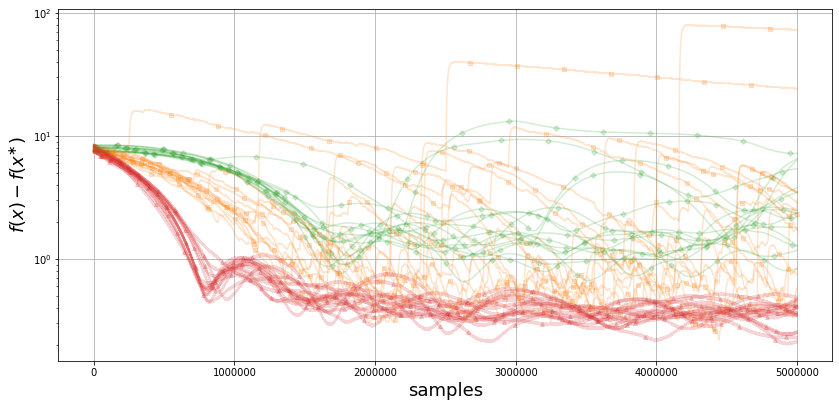

In [7]:
fig = plt.figure(figsize=(12,6))
gs = GridSpec(1,1, figure=fig)

display.clear_output(wait=True)

hists_names_list = [
#     "2023-08-09_01_22_55_train_hist_p_0.0_dataset_normal, n=100,d=16,n_train=50,n_test=50,noise_level=0.0__all_opts_alpha_01_size_50",
#     "2023-08-09_03_17_08_train_hist_p_0.0_dataset_normal, n=1000,d=16,n_train=500,n_test=500,noise_level=0.0__all_opts_alpha_1_size_500",
#     "2023-08-09_07_18_13_train_hist_p_0.0_dataset_normal, n=100,d=16,n_train=50,n_test=50,noise_level=0.0__all_opts_alpha_01_size_50",
    "2023-08-09_13_39_43_train_hist_p_0.0_dataset_normal, n=1000,d=16,n_train=500,n_test=500,noise_level=0.0__all_opts_alpha_1_size_500",
]

lines = [
    'd=16_sgd__zo_l2',
    'd=16_sstm__zo_l2',
    'd=16_clipped_sstm__zo_l2'
]

line_params = {
 'd=16_sgd__zo_l2': {
     "name": "ZO-SGD",
     "line_color": colors[1], "line_style": "-",
     "line_marker": "s", "mark_every": "auto"
 },
 'd=16_sstm__zo_l2': {
     "name": "ZO-SSTM",
     "line_color": colors[2], "line_style": "-",
     "line_marker": "D", "mark_every": "auto"
 },
 'd=16_clipped_sstm__zo_l2': {
     "name": "ZO-clipped-SSTM",
     "line_color": colors[3], "line_style": "-",
     "line_marker": "^", "mark_every": "auto"
 }
}

def key(h):
    return smooth(h[1]["losses"]["train_losses_full"]["ys"], eps=0.1)[-1]

hist_loaded = hist_from_json(load_hist_jsons(hists_names_list, path="./results/zeroth_order_backward/"))
for i, h in enumerate(hist_loaded):
    h["name"] = h["dataset_name"].split(" ")[1].split(",")[1] + "_" + h["name"] + "_" + str(i)

grouped_hist =  dict([(k["name"], k) for k in hist_loaded])

def convert_to_plot_data(data):
    res = []
    for name in data.keys():
        res.append(
            {
                "name": name.split(",")[0],
                "epochs_x": [1],
                "x": data[name]['losses']["train_losses"]["xs"],
                "y": data[name]['losses']["train_losses"]["ys"],
            }
        )
    return res

grouped_hist = convert_to_plot_data(dict(grouped_hist))

ax = fig.add_subplot(gs[0,0])
ax = make_plot(
    ax, grouped_hist, "y", "x",  
    title="", y_label=r"$f(x)-f(x^{\ast})$", x_label="samples", 
    eps=0.01, alpha=0.2, starting_epoch=0, draw_epoch_lines=False, grid=True, 
    mark_every_count=14, title_fontsize=title_fontsize, xy_label_fontsize=18,
    line_params=line_params, yscale="log",legend = False
)

gs.tight_layout(fig)

# PATH = './graphs/train_loss_zo_methods_big_task_n_500_noise_1_average_1_paths_5_noise.pdf'

# plt.savefig(PATH, format='pdf')

plt.draw()
plt.show()

### Final plot

C:\Users\innok\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\innok\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\innok\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\innok\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\innok\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


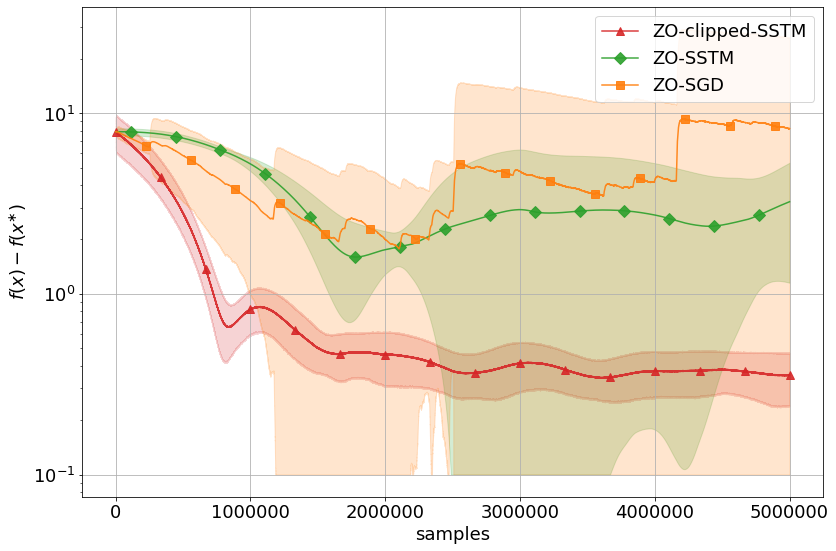

In [8]:
fig = plt.figure(figsize=(12,8))
gs = GridSpec(1,1, figure=fig)

display.clear_output(wait=True)

hists_names_list = [
#     "2023-08-09_01_22_55_train_hist_p_0.0_dataset_normal, n=100,d=16,n_train=50,n_test=50,noise_level=0.0__all_opts_alpha_01_size_50",
#     "2023-08-09_03_17_08_train_hist_p_0.0_dataset_normal, n=1000,d=16,n_train=500,n_test=500,noise_level=0.0__all_opts_alpha_1_size_500",
#     "2023-08-09_07_18_13_train_hist_p_0.0_dataset_normal, n=100,d=16,n_train=50,n_test=50,noise_level=0.0__all_opts_alpha_01_size_50",
    "2023-08-09_13_39_43_train_hist_p_0.0_dataset_normal, n=1000,d=16,n_train=500,n_test=500,noise_level=0.0__all_opts_alpha_1_size_500",
]

lines = [
    'd=16_sgd__zo_l2',
    'd=16_sstm__zo_l2',
    'd=16_clipped_sstm__zo_l2'
]

line_params = {
 'd=16_sgd__zo_l2': {
     "name": "ZO-SGD",
     "line_color": colors[1], "line_style": "-",
     "line_marker": "s", "mark_every": "auto"
 },
 'd=16_sstm__zo_l2': {
     "name": "ZO-SSTM",
     "line_color": colors[2], "line_style": "-",
     "line_marker": "D", "mark_every": "auto"
 },
 'd=16_clipped_sstm__zo_l2': {
     "name": "ZO-clipped-SSTM",
     "line_color": colors[3], "line_style": "-",
     "line_marker": "^", "mark_every": "auto"
 }
}

def key(h):
    return smooth(h[1]["losses"]["train_losses_full"]["ys"], eps=0.1)[-1]

hist_loaded = hist_from_json(load_hist_jsons(hists_names_list, path="./results/zeroth_order_backward/"))
for h in hist_loaded:
    h["name"] = h["dataset_name"].split(" ")[1].split(",")[1] + "_" + h["name"]

hist_loaded = group_uniques(hist_loaded, norm_train=False, name_type="name", center_train=True, calc_std=True)

hist = [(k, hist_loaded[k]) for k in hist_loaded]

hist = sorted(hist, key=key)

hist = select_top(
    hist, 
    lines,
    top_k=1
)

grouped_hist = sorted(hist, key=key)
grouped_hist = dict(grouped_hist)

def convert_to_plot_data(data):
    res = []
    for name in data.keys():
        res.append(
            {
                "name": name.split(",")[0],
                "epochs_x": [1],
                "x": data[name]['losses']["train_losses"]["xs"],
                "y": data[name]['losses']["train_losses"]["ys"],
                "y_std": data[name]['losses']["train_losses"]["ys_std"],
#                 "x": data[name]['losses']["train_losses_full"]["xs"],
#                 "y": data[name]['losses']["train_losses_full"]["ys"],
#                 "y_std": data[name]['losses']["train_losses_full"]["ys_std"],
            }
        )
    return res

grouped_hist = convert_to_plot_data(dict(grouped_hist))

ax = fig.add_subplot(gs[0,0])
ax = make_plot(
    ax, grouped_hist, "y", "x",  
    title="", y_label=r"$f(x)-f(x^{\ast})$", x_label="samples", 
    eps=0.01, alpha=0.9, starting_epoch=0, draw_epoch_lines=False, grid=True, 
    mark_every_count=14, title_fontsize=title_fontsize, xy_label_fontsize=18,
    line_params=line_params, yscale="log", draw_stds=True, markersize=8
)

gs.tight_layout(fig)

PATH = './graphs/train_loss_zo_methods_big_task_n_500_noise_1_average_3_paths_5_noise.pdf'

plt.savefig(PATH, format='pdf')

plt.draw()
plt.show()